The problem we are trying to solve is the determination of a person wearing a face mask in a given photo or image and this is important because since the emergence of the COVID-19 pandemic in early 2020, all sorts of measures have been put into place by governments all across the world to reduce and mitigate the spread of infection


The dataset used for this project was obtained from an open-source  Machine Learning website called Kaggle, the following is the url: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset 
https://github.com/avishshah11/FaceMask-Detection
https://github.com/AI-TECHED/Face-Mask-Detection
https://github.com/balajisrinivas/Face-Mask-Detection

The dataset which was used in this project can be found in the folder named dataset. 


The number of classes we have classified within the dataset are five. The following are the names of the classes: no_mask, cloth, N95, N95_valve, surgical. 

However the dataset which we got from the open source only had the bare minimum, hence we used data augmentation to over come this issue.  We had only 100 images  for each class from the online dataset, after data augmentation we have a 1000 images for each of the classes. Hence in total of 5000 images. 

## Imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd
import os
from tabulate import tabulate

In [3]:
# Suppresses the tensorflow messages in the prints
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

## Variable Declarations

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
# initialize the initial learning rate, number of epochs to train for,
# and batch size
Learning_Rate = 1e-4
Number_of_Epochs = 20
batch_size = 32

DIRECTORY = r"dataset"
type_of_masks = [ "no_mask", "cloth", "N95", "N95_valve", "surgical"]


df = pd.DataFrame({ 'Abbreviation': ['lr', 'ep', 'bs'], 'Terminology': ['Learning Rate', 'Epoch', 'Batch Size'], 'Value': [Learning_Rate, Number_of_Epochs, batch_size]})
print()
print('\033[94mConfigure the number of epochs and learning rate for model training')
print()
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))
print()
print(f'Detecting the two different mask types: {", ".join(map(str, type_of_masks))}')


Configure the number of epochs and learning rate for model training

+----------------+---------------+---------+
| Abbreviation   | Terminology   |   Value |
|----------------+---------------+---------|
| lr             | Learning Rate |  0.0001 |
| ep             | Epoch         | 20      |
| bs             | Batch Size    | 32      |
+----------------+---------------+---------+

Detecting the two different mask types: no_mask, cloth, N95, N95_valve, surgical


## Data Preparation

In [5]:
dataset = []
mask_label = []


image_size = 224

for mask_type_category in type_of_masks:
	path = os.path.join(DIRECTORY, mask_type_category)
	for img in os.listdir(path):
		image_pathway = os.path.join(path, img)
		image = load_img(image_pathway, target_size=(image_size, image_size))
		image = img_to_array(image)
		image = preprocess_input(image)

		dataset.append(image)
		mask_label.append(mask_type_category)
print('\033[92m[COMPLETE] Data Prepation completed')

# one hot encoding
print('\033[93m[IN PROGRESS] Converting categories into hot-one numerical value variables')
# perform one-hot encoding on the labels
label_encoder = LabelEncoder()
#label_encoder = LabelEncoder()
#integer_encoded = label_encoder.fit_transform(values)
mask_label = label_encoder.fit_transform(mask_label)
mask_label = to_categorical(mask_label)
print('\033[92m[COMPLETE] Converting categories into hot-one numerical value variables')

print('\033[93m[IN PROGRESS] Converting data into numpy array')
mask_label = np.array(mask_label)
dataset = np.array(dataset, dtype="float32")
print('\033[92m[COMPLETE] Converting data into numpy array\n')
print(f'\033[94mTotal of {len(dataset)} images processed')

[COMPLETE] Data Prepation completed
[IN PROGRESS] Converting categories into hot-one numerical value variables
[COMPLETE] Converting categories into hot-one numerical value variables
[IN PROGRESS] Converting data into numpy array
[COMPLETE] Converting data into numpy array

Total of 5000 images processed


## Data Processing and Augmentation

In [6]:
# Using the train_test split to effectively split the training data into testing and training data
# Using the 20% for the test data
print('\033[93m[IN PROGRESS] Splitting datasets into testing and training data')
(trainX, testX, trainY, testY) = train_test_split(dataset, mask_label,
	test_size=0.17, stratify=mask_label, random_state=42)
print('\033[92m[COMPLETE] Splitting datasets into testing and training data')

df = pd.DataFrame({ 'Type of Training': ['Testing Dataset', 'Training Dataset',], 'Testing Size': ['20%', '80%']})

print('\n\033[94mTraining Size Split Summary')
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False), "\n")

# Using image generator for data augmentation
print('\033[93m[IN PROGRESS] Data Augmentation with ImageDataGenerator')
image_augmentation = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
print('\033[92m[COMPLETE] Data Augmentation with ImageDataGenerator')

[IN PROGRESS] Splitting datasets into testing and training data
[COMPLETE] Splitting datasets into testing and training data

Training Size Split Summary
+--------------------+----------------+
| Type of Training   | Testing Size   |
|--------------------+----------------|
| Testing Dataset    | 20%            |
| Training Dataset   | 80%            |
+--------------------+----------------+ 

[IN PROGRESS] Data Augmentation with ImageDataGenerator
[COMPLETE] Data Augmentation with ImageDataGenerator


MODEL:

Keeping learning rate low so we could achieve a better accuracy earlier in our model.
After trying different values, we observed that these values resulted to best performance of our model.

We are using MobileNet in our model instead of a CNN layer as it results to faster processing. The MobileNet which we use generates 2 different models, the head and the base model. The base model in our code is denoted as the basic model. It uses a pre-trained model which is used specifically for images. This resulted to us observing better results.  Then we the head model which uses our base model (basic model) output. The head model in our code is denoted as root_model.

## CNN Architecture with MobileNetV2

In [7]:
# load the MobileNetV2 network without root layer
# MobileNetV2 is faster than the traditional CNN
print('\033[93m[IN PROGRESS] Creating a base model')
basic_model = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(image_size, image_size, 3)))
print('\033[92m[COMPLETE] Base model created')

print('\033[93m[IN PROGRESS] Building on top of the base model with activation functions')
# Relu is a go-to activation function for a non-linear use-cases
# root_model for top layer
root_Model = basic_model.output
root_Model = AveragePooling2D(pool_size=(6, 6))(root_Model)
root_Model = Flatten(name="flatten")(root_Model)
root_Model = Dense(128, activation="relu")(root_Model)
root_Model = Dropout(0.5)(root_Model)
root_Model = Dense(5, activation="softmax")(root_Model)
print('\033[92m[COMPLETE] Building on top of the base model with activation functions')


# actual model to train
model = Model(inputs=basic_model.input, outputs=root_Model)

# temporarily stopping the base model from being trained so they are 
# not updated in initial training
for layer in basic_model.layers:
	layer.trainable = False

[IN PROGRESS] Creating a base model
[COMPLETE] Base model created
[IN PROGRESS] Building on top of the base model with activation functions
[COMPLETE] Building on top of the base model with activation functions


## Training Results

In [8]:
optimizer = Adam(learning_rate=Learning_Rate, decay=Learning_Rate / Number_of_Epochs)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
	metrics=["accuracy"])

print('\033[93m[IN PROGRESS] Training head of network\n')
print('\033[94m')
model_head = model.fit(
	image_augmentation.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=Number_of_Epochs)
print('\033[92m[COMPLETE] Training head of network')

print('\033[93m[IN PROGRESS] Evaluating network and making predictions on testing set')
prediction_based_on_testX = model.predict(testX, batch_size=batch_size)
print('\033[92m[COMPLETE] Evaluating network and making predictions on testing set\n')

# index for image with largest probability
prediction_based_on_testX = np.argmax(prediction_based_on_testX, axis=1)

# classification report
print(classification_report(testY.argmax(axis=1), prediction_based_on_testX,
	target_names=label_encoder.classes_))


[IN PROGRESS] Training head of network


Epoch 1/20
129/129 [==============================] - 52s 377ms/step - loss: 0.5248 - accuracy: 0.3692 - val_loss: 0.3574 - val_accuracy: 0.6580
Epoch 2/20
129/129 [==============================] - 49s 381ms/step - loss: 0.3724 - accuracy: 0.5934 - val_loss: 0.2892 - val_accuracy: 0.7203
Epoch 3/20
129/129 [==============================] - 56s 438ms/step - loss: 0.3230 - accuracy: 0.6524 - val_loss: 0.2515 - val_accuracy: 0.7709
Epoch 4/20
129/129 [==============================] - 53s 407ms/step - loss: 0.2965 - accuracy: 0.7022 - val_loss: 0.2332 - val_accuracy: 0.7826
Epoch 5/20
129/129 [==============================] - 54s 418ms/step - loss: 0.2731 - accuracy: 0.7284 - val_loss: 0.2186 - val_accuracy: 0.7932
Epoch 6/20
129/129 [==============================] - 53s 410ms/step - loss: 0.2551 - accuracy: 0.7462 - val_loss: 0.2079 - val_accuracy: 0.7991
Epoch 7/20
129/129 [==============================] - 51s 395ms/step - loss: 0.2444 - acc

## Plotting - Loss and Accuracy

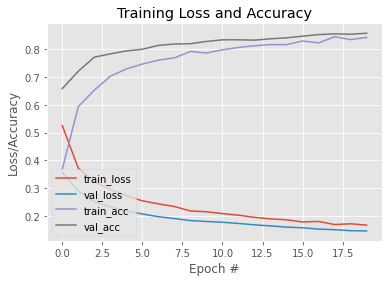

In [9]:
num_epoch = Number_of_Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epoch), model_head.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epoch), model_head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epoch), model_head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epoch), model_head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

## Discussion

Mask Detection model is a combination of face mask classifaction model and real time object detection model. When we were training the face mask detection model we tried using lots of different approaches based on existed literature. The one that worked the best for us was MobileNetV2 and for the weights we used pre trained weights, "imagenet". This gives the highest measures of recall. When we tried running this model on different use cases of different face mask materials we decided to use for this project.

Our initial plan was to use transfer learning to classify different types of face mask. Even though we created big data sets different types of masks, this training method.

From the plot, the results that we achieved, training loss is minimised when the number of epochs reaches 12, and is same after. Training accuracy increases but is almost consistent after 12 epochs as well. and this is the exact same as we predicted. 

## Improvements

Improving the precision we resized the crop faces that we provided as input to the model via video stream. We tried using different layering methods and used the ones which best suites our requirements, as mentioned earlier. 

## Use Cases


This can be used at Hospitals, Police Stations, Bus Stands, Train Stations, Super Markets.


## Saving Model

In [10]:
# serializing model to disk
model.save("mask_detector.model", save_format="h5")
print('\033[92m[COMPLETE] Serializing and saving mask detector model to file')

[COMPLETE] Serializing and saving mask detector model to file
